# Imports

In [13]:
# misc
import sys
import os

# load/save files
import zipfile
import json

# plot
import matplotlib.pyplot as plt
from PIL import Image

# datascience libs
import numpy as np
import pandas as pd



try: # python
    path_ = os.path.join(os.path.dirname(os.path.abspath(__file__)), "..")
except NameError: # jupyter notebook
    path_ = os.path.dirname(os.getcwd())

dataset_dir = os.path.join(path_, "datasets")
model_dir = os.path.join(path_, "models")


# Google colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path_ = "/content/drive/MyDrive/"
dataset_dir = os.path.join(path_, "datasets")
model_dir = os.path.join(path_, "models")
dataset_dir_url = ""

# Read mapping file

In [1]:
def emnist_get_mapping(filepath):
    max_index = 0
    data = {}
    with open(filepath) as f:
        while True:
            line = f.readline()
            if not line:
                break
            tmp = [int(s) for s in line.strip().split(' ') if s.isdigit()]
            data[tmp[0]] = tmp[1]
            max_index = max(max_index, tmp[0])
    # create array with size
    emnist_mapping = [-1] * (max_index + 1)
    # dict to array
    for key, val in data.items():
        emnist_mapping[key] = val
    return emnist_mapping

# Converter

## BinPacker class

In [12]:
import random

class BinPackerNode:
    def __init__(self, x=0, y=0, width=0,height=0, data=None, left=None,right=None):
        self.x = x
        self.y = y
        self.width = width
        self.height = height
        self.data = data
        self.left = left
        self.right = right

    def split(self, data, width, height):
        self.data = data
        self.left = BinPackerNode(self.x,self.y+height, self.width, self.height-height)
        self.right = BinPackerNode(self.x+width,self.y, self.width-width, height)
        return self

    @staticmethod
    def find(node, width, height):
        if node.data:
            return BinPackerNode.find(node.right, width, height) or BinPackerNode.find(node.left, width, height)
        elif width <= node.width and height <= node.height:
            return node
        return None


class BinPacker:
    def __init__(self, width, height, verbose=0, percentage_completion=0):
        self.root = BinPackerNode(0,0,width,height)
        self.width = width
        self.height = height
        self.verbose = verbose
        self.percentage_completion = percentage_completion

    cbsort = {
        "w": (lambda a,b: b["width"] - a["width"]),
        "h": (lambda a,b: b["height"] - a["height"]),
        "a": (lambda a,b: b["width"]*b["height"] - a["width"]*a["height"]),
        "max": (lambda a,b: max(b["width"], b["height"]) - max(a["width"], a["height"])),
        "min": (lambda a,b: min(b["width"], b["height"]) - min(a["width"], a["height"])),
        "random": (lambda a,b: random.random() - 0.5),
        "height": (lambda a,b: BinPacker.msort(a, b, ['h','w'])),
        "width": (lambda a,b: BinPacker.msort(a, b, ['w','h'])),
        "area": (lambda a,b: BinPacker.msort(a, b, ['a','h','w'])),
        "maxside": (lambda a,b: BinPacker.msort(a, b, ['max','min','h','w'])),
    }

    @staticmethod
    def msort(a, b, criteria):
        diff = 0
        for n in range(len(criteria)):
            diff = BinPacker.cbsort[criteria[n]](a,b)
            if diff != 0:
                break
        return diff

    @staticmethod
    def swap(a,i,j):
        t = a[i]
        a[i] = a[j]
        a[j] = t

    @staticmethod
    def sort(arr, criteria = ['height']):
        for i in range(0, len(arr)-1):
            for j in range(i+1, len(arr)):
                if BinPacker.msort(arr[i], arr[j], criteria) > 0:
                    BinPacker.swap(arr,i,j)


    def fit(self, blocks_src, criteria = ['height']):
        res = []
        blocks = []

        for i in range(len(blocks_src)):
            blocks.append(blocks_src[i])

        # if criteria doesn't exist, we assume that all boxes have the same size
        if not criteria == None:
            if self.verbose:
                print("Sorting nodes")
            BinPacker.sort(blocks, criteria)

        blocks_count = len(blocks)
        for i in range(blocks_count):
            block = blocks[i]
            w = block["width"]
            h = block["height"]
            node = BinPackerNode.find(self.root, w,h)
            if not node:
                # if criteria doesn't exist, we assume that all boxes have the same size
                if criteria == None:
                     break
                continue
            if not node.split(block["data"] if "data" in block else "empty", w,h):
                continue
            node.width = w
            node.height = h
            res.append(node)

            new_percentage = int((i * 100) / blocks_count)
            if new_percentage > self.percentage_completion:
                self.percentage_completion = new_percentage
                if self.verbose:
                    print("Insert nodes {}%".format(self.percentage_completion))
        return res
    

['/home/nes/code/0r4nd/JAVASCRIPT/__TOOLS__/HandwritingRecognition/notebooks', '/home/nes/code/0r4nd/data-challenges/04-Decision-Science', '/home/nes/code/0r4nd/JAVASCRIPT/__TOOLS__/HandwritingRecognition/notebooks', '/home/nes/.pyenv/versions/3.8.12/lib/python38.zip', '/home/nes/.pyenv/versions/3.8.12/lib/python3.8', '/home/nes/.pyenv/versions/3.8.12/lib/python3.8/lib-dynload', '', '/home/nes/.pyenv/versions/3.8.12/envs/BatteryProject/lib/python3.8/site-packages', '/home/nes/code/0r4nd/JAVASCRIPT/__TOOLS__/HandwritingRecognition\\src']

['/home/nes/code/0r4nd/JAVASCRIPT/__TOOLS__/HandwritingRecognition/notebooks', '/home/nes/code/0r4nd/data-challenges/04-Decision-Science', '/home/nes/code/0r4nd/JAVASCRIPT/__TOOLS__/HandwritingRecognition/notebooks', '/home/nes/.pyenv/versions/3.8.12/lib/python38.zip', '/home/nes/.pyenv/versions/3.8.12/lib/python3.8', '/home/nes/.pyenv/versions/3.8.12/lib/python3.8/lib-dynload', '', '/home/nes/.pyenv/versions/3.8.12/envs/BatteryProject/lib/python3.8/si

## Converter

In [3]:
def makedirs(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
    return


def draw_object(src, sx,sy, s_width,s_height,
                dst, dx,dy, d_width,d_height):
    # src
    s_width_orig = src.shape[1]
    s_height_orig = src.shape[0]
    # dst
    d_width_orig = dst.shape[1]
    d_height_orig = dst.shape[0]
    dx -= sx
    dy -= sy
    for j in range(sy,s_height):
        for i in range(sx,s_width):
            color = src[j][i]
            dst[j+dy][i+dx] = color# if color else 127
    return

def list_first_val(arr):
    for i in arr:
        if i > 0:
            return 1
    return -1

def get_bbox(data):
    """aligned-axis bounding-box (bounding square)"""
    x1 = 0xffff
    y1 = 0xffff
    x2 = 0
    y2 = 0
    # y1
    for j in range(len(data)):
        if list_first_val(data[j]) > 0:
            y1 = j
            break
    # y2
    for j in range(len(data)):
        end = len(data)-j-1
        if list_first_val(data[end]) > 0:
            y2 = end
            break
    # x1, x2
    for j in range(len(data)):
        ydata = data[j]
        val = 0xffff
        last = 0
        for i in range(len(ydata)):
            if ydata[i] > 0:
                x1 = min(x1,i)
                x2 = max(x2,i)
    return [x1,y1, x2+1,y2+1]


def emnist_convert(dataset_dir, input_name, output_dir, emnist_mapping, X_set='train'):
    X_set_dir = os.path.join(dataset_dir, output_dir)
    makedirs(X_set_dir)

    input_file = os.path.join(dataset_dir, input_name+'-'+X_set+'.csv')
    i = 0

    blocks = []
    json_output = {
        "width": 28,
        "height": 28,
        "files": [],
        "id": "",
        "bbox": [],
    }

    print("Read data")
    with open(input_file) as f:
        while True:
            line = f.readline()
            if not line:
                break
            tmp = [int(s) for s in line.strip().split(',') if s.isdigit()]
            pixels = np.array(tmp[1:], dtype='uint8').reshape(28,28)
            pixels = np.flip(pixels, axis=1)
            pixels = np.rot90(pixels, k=1, axes=(0, 1))
            json_output['id'] += chr(emnist_mapping[tmp[0]])
            json_output['bbox'].append(get_bbox(pixels))
            blocks.append({
                "width": 28, "height": 28,
                "data": {
                    "idx": i,
                    "pixels": pixels
                }
            })
            i += 1
            #if i > 2000:
            #    break

    print("Build tree")
    count = 0
    while len(blocks) > 0:
        percentage = packer.percentage_completion if 'packer' in locals() else 0
        packer = BinPacker(4096,4096, verbose=1, percentage_completion = percentage)
        res = packer.fit(blocks, None)
        # advance on the next pack that couldn't be fitted
        blocks = blocks[len(res):]
        dst = np.zeros((packer.width,packer.height), dtype="uint8")
        count_prev = count
        for i in range(len(res)):
            node = res[i]
            if node.data == "empty":
                continue
            count += 1
            draw_object(node.data['pixels'],
                        0,0, 28,28,
                        dst, node.x,node.y, packer.width,packer.height)
        # write image
        image_filename = "X_{}_{}_to_{}.webp".format(X_set,count_prev,count-1)
        image_filename = os.path.join(X_set_dir, image_filename)
        json_output['files'].append(image_filename)
        print("Save:", image_filename)
        img = Image.fromarray(dst, mode='L')
        img.save(image_filename, format='webp', lossless = True)
        # plot image
        #plt.figure(figsize = (20,20))
        #plt.imshow(dst, cmap='gray')
        #plt.show()

    # write json file
    json_filename = os.path.join(X_set_dir, X_set + ".json")
    json_dump = json.dumps(json_output,separators=(',',':'))
    with open(json_filename, 'w', encoding='utf-8') as f:
        f.write(json_dump)
        print("Save:", json_filename)
    print("End")

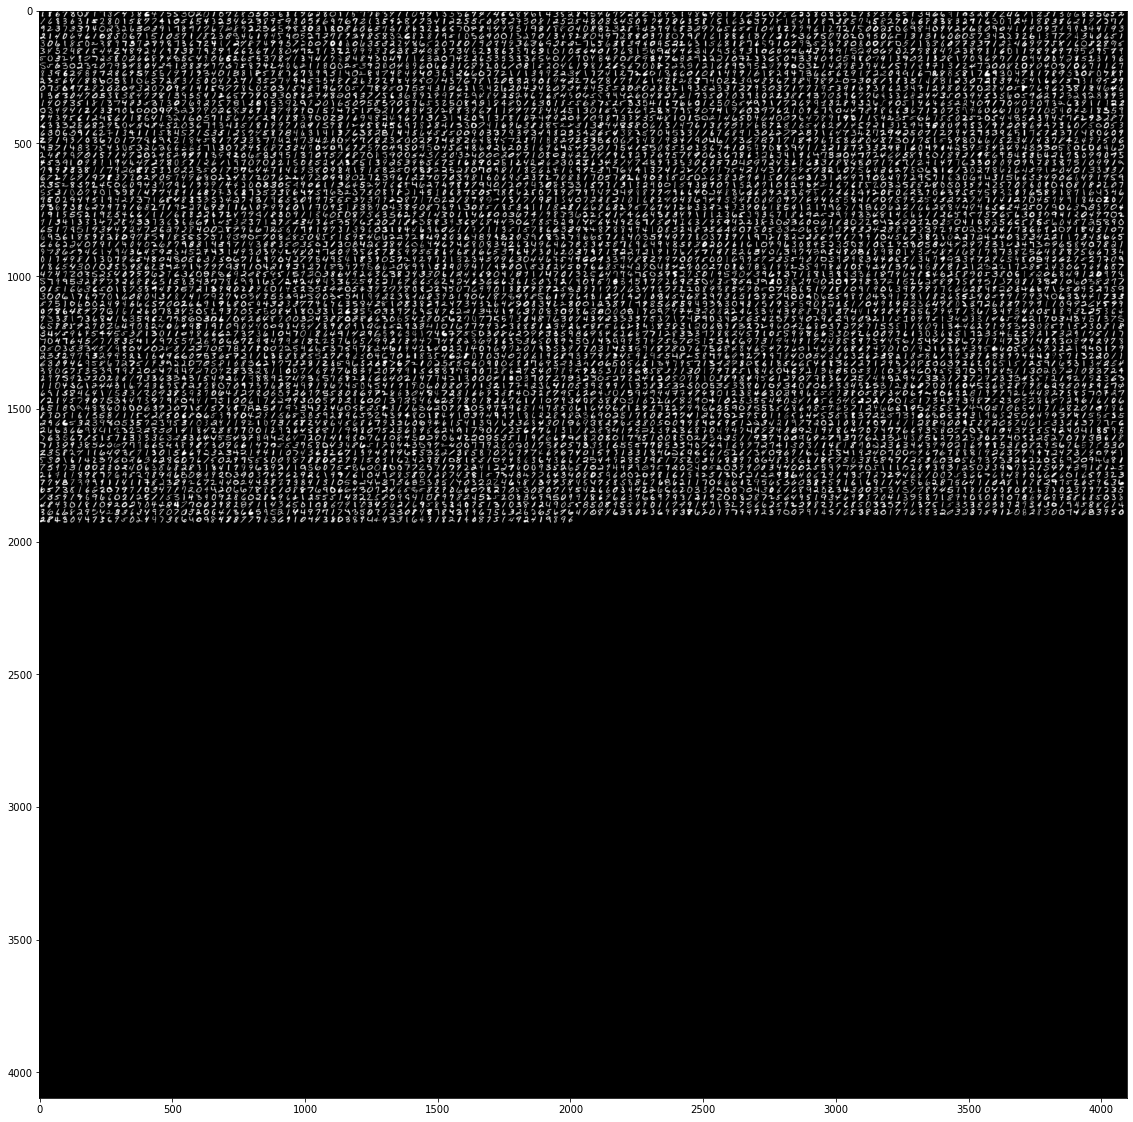

In [25]:
try:
    from types import SimpleNamespace as Namespace
except ImportError:
    from argparse import Namespace

#(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data(path="mnist.npz")
def load_data(dir_path):
    test_path = os.path.join(dir_path, "test.json")
    train_path = os.path.join(dir_path, "train.json")
    with open(test_path, 'r', encoding='utf-8') as f:
        obj = json.loads(f.read(), object_hook = lambda d: Namespace(**d))
    for s in obj.files:
        #print(os.path.basename(s))
        img_path = os.path.join(dir_path, os.path.basename(s))
        img = Image.open(img_path)
        plt.figure(figsize = (20,20))
        plt.imshow(img, cmap='gray')
        plt.show()
        
load_data(os.path.join(dataset_dir, "emnist-mnist"))


## emnist-balanced (best)

In [ ]:
set_name = 'emnist-balanced'
emnist_mapping = emnist_get_mapping(os.path.join(dataset_dir, set_name + '-mapping.txt'))
print("mapping:", emnist_mapping)
emnist_convert(dataset_dir, set_name, 'origin-'+set_name, emnist_mapping, 'test')
emnist_convert(dataset_dir, set_name, 'origin-'+set_name, emnist_mapping, 'train')

## emnist-mnist (basic, only digits)

In [ ]:
set_name = 'emnist-mnist'
emnist_mapping = emnist_get_mapping(os.path.join(dataset_dir, set_name + '-mapping.txt'))
print("mapping:", emnist_mapping)
emnist_convert(dataset_dir, set_name, 'origin-'+set_name, emnist_mapping, 'test')
emnist_convert(dataset_dir, set_name, 'origin-'+set_name, emnist_mapping, 'train')